In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.applications import VGG16
from keras.applications import ResNet101

from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

ImportError: cannot import name 'EfficientNetB0' from 'keras.applications' (c:\Users\AILABSERVER\anaconda3\envs\suresh\lib\site-packages\keras\applications\__init__.py)

In [4]:
train_path = './train'
test_path = './test'
val_path = './val'

In [5]:

train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
)

In [6]:
size_images = 150
batch_size = 32

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

Found 31571 images belonging to 4 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [7]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


In [8]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 6765 images belonging to 4 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

# Build your custom CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(size_images, size_images, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Assuming num_classes is the number of your classes

# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

# Compile the model with an initial learning rate
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Set up callbacks
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

# Use the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, lr_callback]
)


2024-01-12 12:55:11.197400: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [10]:
test_results = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

211/211 [==============================] - 28s 134ms/step - loss: 0.0595 - accuracy: 0.9816
Test Loss: 0.05952201038599014
Test Accuracy: 0.9816350936889648


In [11]:
# Save the model
model.save('cnn3_model.h5')

/home/aiworkstation1/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('cnn3_model.h5')

# Create a test generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

# Initialize lists to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Loop through all batches in the test generator
for _ in range(len(test_generator)):
    images, labels = test_generator.next()

    # Predictions on the current batch
    batch_predictions = loaded_model.predict(images)
    all_predictions.extend(batch_predictions)
    
    # True labels for the current batch
    batch_true_labels = np.argmax(labels, axis=1)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Extract predicted labels from all predictions
predicted_labels = np.argmax(all_predictions, axis=1)


Found 6769 images belonging to 4 classes.
1/1 [==============================] - 0s 138ms/step


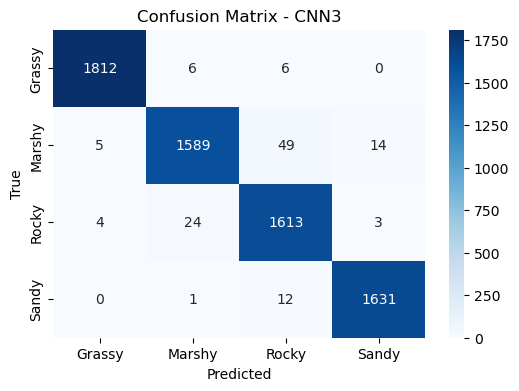

In [13]:
# Confusion Matrix
conf_mat = confusion_matrix(all_true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - CNN3')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:

# Classification Report
print("Classification Report of CNN3:")
print(classification_report(all_true_labels, predicted_labels, target_names=class_names))


Classification Report of CNN3:
              precision    recall  f1-score   support

      Grassy       1.00      0.99      0.99      1824
      Marshy       0.98      0.96      0.97      1657
       Rocky       0.96      0.98      0.97      1644
       Sandy       0.99      0.99      0.99      1644

    accuracy                           0.98      6769
   macro avg       0.98      0.98      0.98      6769
weighted avg       0.98      0.98      0.98      6769



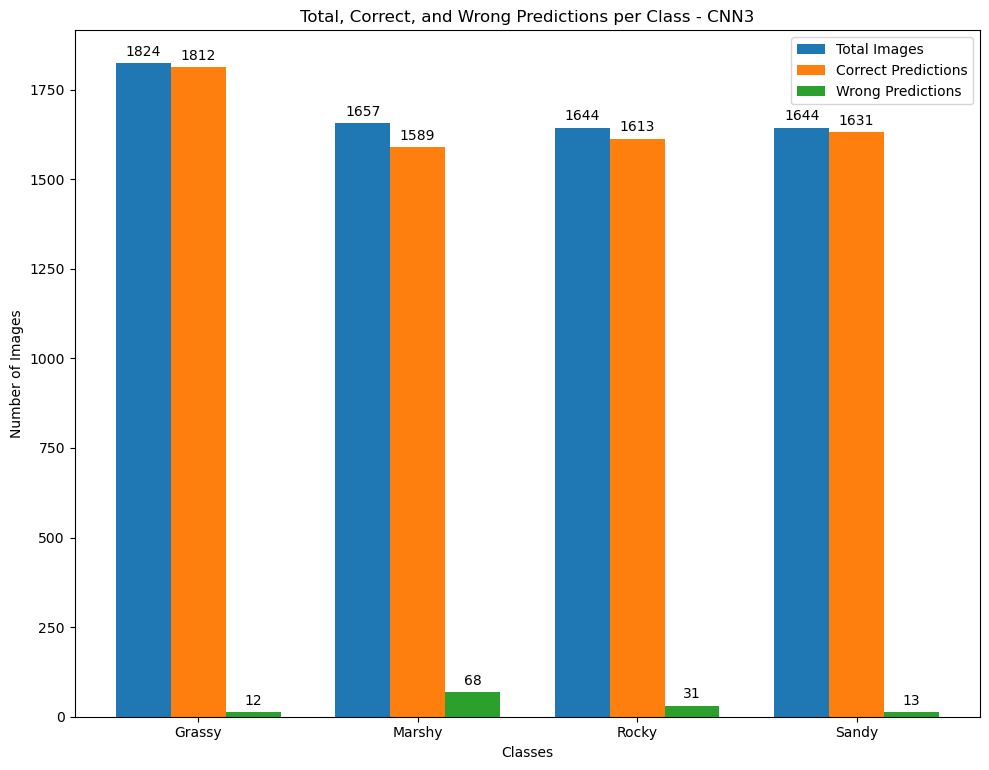

In [15]:
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names

# Print the number of images classified correctly and wrongly in each class
correctly_classified = np.diag(conf_mat)
wrongly_classified = np.sum(conf_mat, axis=1) - correctly_classified

# Total number of images in each class
total_images_per_class = np.sum(conf_mat, axis=1)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_images_per_class, width, label='Total Images')
rects2 = ax.bar(x, correctly_classified, width, label='Correct Predictions')
rects3 = ax.bar(x + width, wrongly_classified, width, label='Wrong Predictions')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Total, Correct, and Wrong Predictions per Class - CNN3')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Display the number of images on top of each bar with proper spacing
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 1.3])  # Increase the value in the last argument if necessary

plt.show()

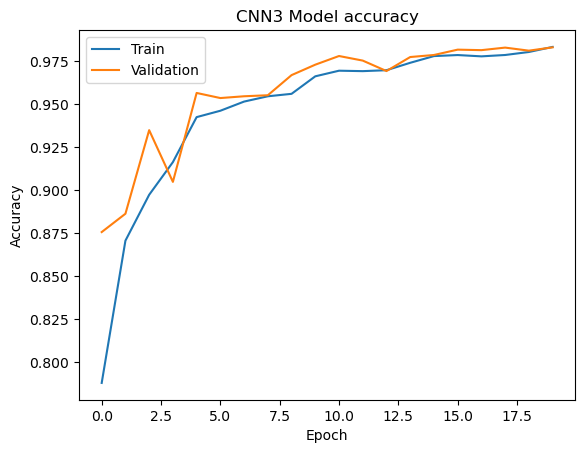

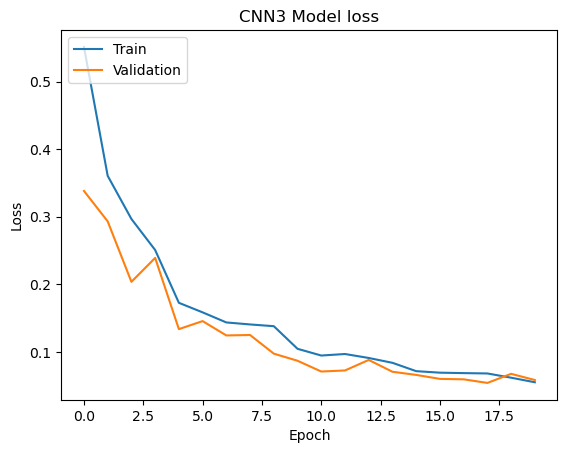

In [16]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object you get after training your DenseNet model
# Replace 'history' with the actual variable name you have

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN3 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN3 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
